In [1]:
# Imports
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [2]:
# Dataset Path
DATASET_PATH = r"D:\6. WIN SEM -- 2024-2025\F1. DL\Child Surveillance DL Project\Datasets\3. Behavioral Analysis\FER-2013\train"

In [3]:
# Image Constraints
IMG_SIZE = 224
IMAGES_PER_CLASS = 300  # You can tweak this
CATEGORIES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
# Define which classes are normal (0) and abnormal (1)
normal_classes = ['happy', 'neutral']
abnormal_classes = ['angry', 'disgust', 'fear', 'sad', 'surprise']

In [5]:
# Initialize data and labels
X, y = [], []

for class_name in CATEGORIES:
    folder = os.path.join(DATASET_PATH, class_name)
    files = os.listdir(folder)[:IMAGES_PER_CLASS]
    label = 0 if class_name in normal_classes else 1  # 0 = normal, 1 = abnormal

    for fname in files:
        path = os.path.join(folder, fname)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32') / 255.0
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Dataset loaded: {X.shape[0]} images")


Dataset loaded: 2100 images


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 1680
Testing samples: 420


In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # Fine-tune

# Optionally freeze some early layers
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [8]:
# Model Training
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


53/53 [==============================] - 104s 2s/step - loss: 0.6211 - accuracy: 0.6935 - val_loss: 0.6206 - val_accuracy: 0.7119
Epoch 2/20
53/53 [==============================] - 81s 2s/step - loss: 0.3702 - accuracy: 0.8351 - val_loss: 0.6024 - val_accuracy: 0.7238
Epoch 3/20
53/53 [==============================] - 75s 1s/step - loss: 0.2096 - accuracy: 0.9262 - val_loss: 0.5891 - val_accuracy: 0.7143
Epoch 4/20
53/53 [==============================] - 74s 1s/step - loss: 0.1031 - accuracy: 0.9738 - val_loss: 0.6878 - val_accuracy: 0.7119
Epoch 5/20
53/53 [==============================] - 75s 1s/step - loss: 0.0516 - accuracy: 0.9899 - val_loss: 0.7701 - val_accuracy: 0.7238
Epoch 6/20
53/53 [==============================] - 82s 2s/step - loss: 0.0240 - accuracy: 0.9976 - val_loss: 0.7506 - val_accuracy: 0.7238
Epoch 7/20
53/53 [==============================] - 85s 2s/step - loss: 0.0130 - accuracy: 0.9988 - val_loss: 0.7582 - val_accuracy: 0.7286
Epoch 8/20
53/53 

In [9]:
# Evaluate the model on the test set.
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


14/14 [==============================] - 9s 656ms/step - loss: 2.7817 - accuracy: 0.7357
Test Loss: 2.7817
Test Accuracy: 73.57%


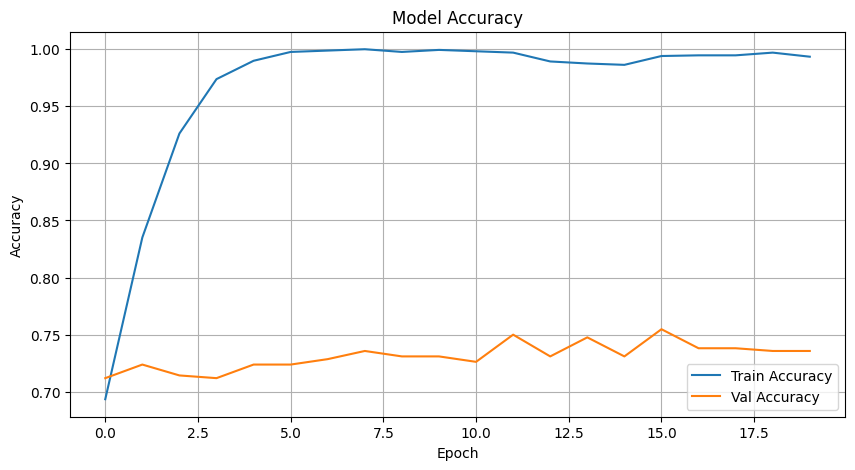

In [10]:
# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

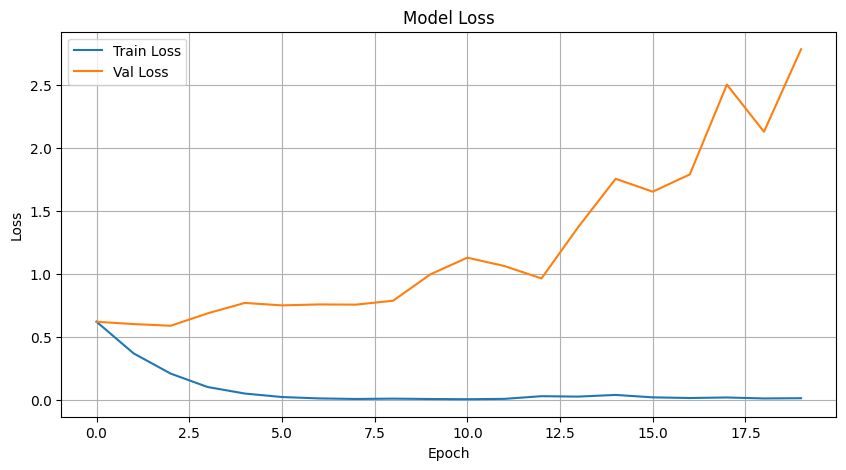

In [11]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
model.save("behaviour_analysis.keras")